# Aula 5.2: Combinando clustering e criando mapas com a API do IBGE

Na aula anterior, vimos alguns conceitos importantes sobre clustering a partir de bases de dados.*texto em itálico*

Neste exercício, iremos reutilizar a [API do IBGE](https://servicodados.ibge.gov.br/api/docs/) para construir mapas a partir de shapes. Isso é particularmente útil quando queremos trabalhar com shapes complexos no ambiente do colab em vez de fazer o processo manual de importar os shapes. 

A [API de malhas](https://servicodados.ibge.gov.br/api/docs/malhas?versao=3) provê malhas simplificadas referentes às unidades político-administrativas do Brasil bem como meso e microrregiões, institucionalizadas pela aprovação da presidência do IBGE da resolução PR nº 51/1989 e pela publicação Divisão regional do Brasil em mesorregiões e microrregiões geográficas, desenvolvidas a partir das malhas originais do IBGE.

Seu uso é ideal para aplicações web, em que imagens leves fazem com que as páginas sejam carregadas rapidamente. Caso contrário, se fosse usada a malha original, o carregamento da página faria com que seu uso ficasse inviável. Outro caso de uso de malhas simplificadas é para impressos em que seja aceitável um nível de detalhamento simplificado ou por causa de restrições de processamento do computador, na qual uma malha original poderia consumir recursos computacionais a ponto de prejudicar o processamento.

Os tipos de dados comuns de exportação são: `json`, `geojson` e `svg`. 

Vamos tentar obter a malha de shapes por municípío, usando a própria [query builder](https://servicodados.ibge.gov.br/api/docs/malhas?versao=3#api-bq) da API


In [1]:
import requests                    # api module
import json
import pandas as pd

#Obtendo os shapes
url = 'https://servicodados.ibge.gov.br/api/v3/malhas/estados/23?formato=application/vnd.geo+json&qualidade=minima&intrarregiao=municipio'
response = requests.get(url)
shapesJson = response.json()
print(shapesJson)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-38.9699, -7.4273], [-38.962, -7.3959], [-39.0005, -7.3085], [-39.0495, -7.2916], [-39.0918, -7.2597], [-39.0812, -7.3012], [-39.1021, -7.3404], [-39.0782, -7.422], [-38.9699, -7.4273]]]}, 'properties': {'codarea': '2300101'}}, {'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-38.6188, -4.1635], [-38.6535, -4.1577], [-38.7175, -4.1872], [-38.7069, -4.2478], [-38.7207, -4.2799], [-38.6869, -4.2871], [-38.6524, -4.2462], [-38.6122, -4.226], [-38.5705, -4.2355], [-38.6144, -4.1829], [-38.6188, -4.1635]]]}, 'properties': {'codarea': '2300150'}}, {'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-39.9424, -2.8664], [-39.9656, -2.8514], [-40.1262, -2.8235], [-40.1438, -2.8402], [-40.1884, -2.8124], [-40.2367, -2.815], [-40.3261, -2.8061], [-40.3719, -2.8124], [-40.3613, -2.8668], [-40.3244, -2.8613], [-40.1959, -2.8731], [-40.151, -2.8842],

Excelente, conseguimos carregar o arquivo .geoson relativo aos shapes dos municípios do estado do ceará. Podemos editar a query passando como parâmetro algum outro valor de identificador de estado.

Vamos novamente obter o PIB per capita do estado do ceará:

In [2]:
#Obtendo os PIB per capita
url = 'https://servicodados.ibge.gov.br/api/v3/agregados/3974/periodos/2010/variaveis/3948?localidades=N6[N3[23]]&classificacao=12085[100543]|58[95253]'
response = requests.get(url)
pib = response.json()
for item in pib:
  for key in item['resultados']:
    pibJson = key
pibJson.pop('classificacoes')
dfPIB = pd.json_normalize(pibJson['series'])
dfPIB.head()

localidade.id localidade.nivel.id localidade.nivel.nome localidade.nome  \
0       2300101                  N6             Município    Abaiara - CE   
1       2300150                  N6             Município    Acarape - CE   
2       2300200                  N6             Município     Acaraú - CE   
3       2300309                  N6             Município   Acopiara - CE   
4       2300408                  N6             Município     Aiuaba - CE   

  serie.2010  
0      240.9  
1      274.9  
2      276.3  
3      292.6  
4      222.9

Vamos fazer alguns ajustes no dataframe importado:

In [3]:
dfPIB[['CIDADE','UF']] = dfPIB[dfPIB.columns[3]].str.split(' - ',1).tolist()
dfPIB.head()

localidade.id localidade.nivel.id localidade.nivel.nome localidade.nome  \
0       2300101                  N6             Município    Abaiara - CE   
1       2300150                  N6             Município    Acarape - CE   
2       2300200                  N6             Município     Acaraú - CE   
3       2300309                  N6             Município   Acopiara - CE   
4       2300408                  N6             Município     Aiuaba - CE   

  serie.2010    CIDADE  UF  
0      240.9   Abaiara  CE  
1      274.9   Acarape  CE  
2      276.3    Acaraú  CE  
3      292.6  Acopiara  CE  
4      222.9    Aiuaba  CE

In [4]:
dfPIB.drop(columns=[dfPIB.columns[1],
                    dfPIB.columns[2],
                    dfPIB.columns[3]],
           inplace=True)
dfPIB.rename(columns = {dfPIB.columns[0]:'ID', 
                       dfPIB.columns[1]: 'PIB'},
             inplace = True)
dfPIB.set_index('ID', inplace = True)
dfPIB['PIB']=dfPIB['PIB'].astype(float)
dfPIB.head()

PIB    CIDADE  UF
ID                          
2300101  240.9   Abaiara  CE
2300150  274.9   Acarape  CE
2300200  276.3    Acaraú  CE
2300309  292.6  Acopiara  CE
2300408  222.9    Aiuaba  CE

Agora iremos combinar o arquivo de shapes importado e os PIBs per capitas em um mapa cloroplético:

In [5]:
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot, download_plotlyjs
br_lat = -6
br_lon = -38.0
brazilMap = px.choropleth_mapbox(dfPIB,
                geojson=shapesJson, 
                locations=dfPIB.index,
                hover_name = 'CIDADE',
                color='PIB', 
                color_continuous_scale="Viridis",
                featureidkey="properties.codarea",
                )
brazilMap.update_layout(mapbox_style="open-street-map", 
                            mapbox_zoom=5, 
                            mapbox_center = {"lat": br_lat, "lon": br_lon},
                            title="PIB per capita - Estado do Ceará")
brazilMap.show()

Veja que a qualidade escolhida para importação do arquivo geojson foi mantida em `mínima`. Vamos utilizar um arquivo na qualidade máxima.

In [6]:
import requests                    # api module
import json
import pandas as pd

#Obtendo os shapes
url = 'https://servicodados.ibge.gov.br/api/v3/malhas/estados/23?formato=application/vnd.geo+json&qualidade=maxima&intrarregiao=municipio'
response = requests.get(url)
shapesJson = response.json()
print(shapesJson)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-38.9699, -7.4273], [-38.969, -7.4248], [-38.9667, -7.4106], [-38.9663, -7.4093], [-38.9632, -7.4052], [-38.9628, -7.4044], [-38.9621, -7.3992], [-38.962, -7.3959], [-38.9626, -7.3952], [-38.9729, -7.3812], [-38.974, -7.3796], [-38.9752, -7.375], [-38.981, -7.3546], [-38.9864, -7.3349], [-38.9868, -7.3335], [-38.9914, -7.3238], [-39.0005, -7.3085], [-39.0013, -7.3074], [-39.0049, -7.3058], [-39.0076, -7.3052], [-39.0098, -7.3029], [-39.0112, -7.3023], [-39.0164, -7.3024], [-39.0183, -7.3021], [-39.0235, -7.2994], [-39.0279, -7.2992], [-39.0337, -7.2974], [-39.0361, -7.295], [-39.0374, -7.2945], [-39.0495, -7.2916], [-39.0673, -7.28], [-39.0685, -7.2791], [-39.0717, -7.2735], [-39.081, -7.2671], [-39.0849, -7.2661], [-39.0856, -7.2657], [-39.0898, -7.2607], [-39.0918, -7.2597], [-39.091, -7.2623], [-39.0901, -7.2634], [-39.0898, -7.2654], [-39.0859, -7.2665], [-39.0853, -7.26

Vamos aproveitar para modificar a escala de cores do mapa, de acordo com a [documentação do plotly](https://plotly.com/python/builtin-colorscales/):

In [7]:
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot, download_plotlyjs
br_lat = -6
br_lon = -38.0
brazilMap = px.choropleth_mapbox(dfPIB,
                geojson=shapesJson, 
                locations=dfPIB.index,
                hover_name = 'CIDADE',
                color='PIB', 
                color_continuous_scale="YlGnBu",
                featureidkey="properties.codarea",
                )
brazilMap.update_layout(mapbox_style="open-street-map", 
                            mapbox_zoom=5, 
                            mapbox_center = {"lat": br_lat, "lon": br_lon},
                            title="PIB per capita - Estado do Ceará")
brazilMap.show()

Você consegue notar alguma diferença?

Voltaremos a fazer um clustering entre as cidades des estados do CE e PE. Voltaremos ao shape antigo, menos complexo:

In [8]:
import requests                    # api module
import json
import pandas as pd

#Obtendo os shapes
url = 'https://servicodados.ibge.gov.br/api/v3/malhas/estados/23?formato=application/vnd.geo+json&qualidade=minima&intrarregiao=municipio'
response = requests.get(url)
shapesJsonCE = response.json()


#Obtendo os shapes
url = 'https://servicodados.ibge.gov.br/api/v3/malhas/estados/26?formato=application/vnd.geo+json&qualidade=minima&intrarregiao=municipio'
response = requests.get(url)
shapesJsonPE = response.json()

Aqui, obtivemos dois shapes dos dois estados (CE e PE). Iremos junta-los em um só:

In [9]:
shapesJson['features'] = shapesJsonCE['features'] + shapesJsonPE['features']

Agora, iremos obter novamente os dados de PIB per capita dos estados:

In [10]:
# Obtendo os dados per capita - ceará e pernambuco
url = 'https://servicodados.ibge.gov.br/api/v3/agregados/3974/periodos/2010/variaveis/3948?localidades=N6[N3[23,26]]&classificacao=12085[100543]|58[95253]'
response = requests.get(url)
pib = response.json()
for item in pib:
  for key in item['resultados']:
    pibJson = key
pibJson.pop('classificacoes')
dfPIB = pd.json_normalize(pibJson['series'])
dfPIB[['CIDADE','UF']] = dfPIB[dfPIB.columns[3]].str.split(' - ',1).tolist()
dfPIB.drop(columns=[dfPIB.columns[1],
                    dfPIB.columns[2],
                    dfPIB.columns[3]],
           inplace=True)
dfPIB.rename(columns = {dfPIB.columns[0]:'ID', 
                       dfPIB.columns[1]: 'PIB'},
             inplace = True)
dfPIB.set_index('ID', inplace = True)
new_columns = (dfPIB.columns.drop('PIB').tolist()) + ['PIB']
dfPIB = dfPIB[new_columns]
dfPIB.head()

CIDADE  UF    PIB
ID                          
2300101   Abaiara  CE  240.9
2300150   Acarape  CE  274.9
2300200    Acaraú  CE  276.3
2300309  Acopiara  CE  292.6
2300408    Aiuaba  CE  222.9

Vamos obter também as informações de densidade populacional:

In [11]:
# Obtendo a densidade populacional: Ceará e Pernambuco
url = "https://servicodados.ibge.gov.br/api/v3/agregados/1301/periodos/2010/variaveis/616?localidades=N6[N3[23,26]]"

response = requests.get(url)
dens = response.json()
for item in dens:
  for key in item['resultados']:
    densJson = key
densJson.pop('classificacoes')
dfDens = pd.json_normalize(densJson['series'])
dfDens.drop(columns=[dfDens.columns[1],
                    dfDens.columns[2],
                    dfDens.columns[3]],
           inplace=True)
dfDens.rename(columns = {dfDens.columns[0]:'ID', 
                       dfDens.columns[1]: 'DENS'},
             inplace = True)
dfDens.set_index('ID', inplace = True)
dfDens.head()

DENS
ID            
2300101  58.69
2300150  95.69
2300200  68.31
2300309  22.70
2300408   6.66

Vamos concatenar esses dados em um único dataframe:

In [12]:
dfPIBDens = pd.merge(dfPIB, dfDens, on="ID")
dfPIBDens[['PIB','DENS']]=dfPIBDens[['PIB','DENS']].astype(float)
dfPIBDens.head()

CIDADE  UF    PIB   DENS
ID                                 
2300101   Abaiara  CE  240.9  58.69
2300150   Acarape  CE  274.9  95.69
2300200    Acaraú  CE  276.3  68.31
2300309  Acopiara  CE  292.6  22.70
2300408    Aiuaba  CE  222.9   6.66

Vamos aplicar o mesmo método para clusterização da aula anterior:

In [13]:
X = dfPIBDens[['DENS', 'PIB']].to_numpy()

Vamos usar o KMeans da ScikitLearn:

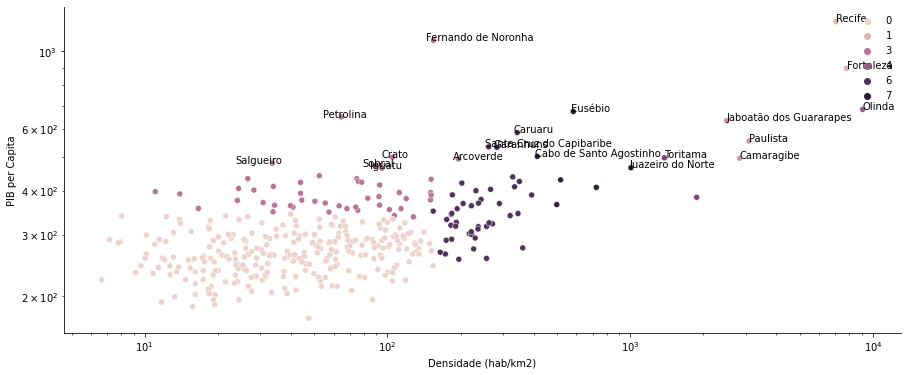

In [16]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

cl = KMeans(n_clusters=8, random_state=0).fit(X)
clusters = pd.DataFrame(cl.labels_, columns=['cluster'])
detail = pd.merge(left=dfPIBDens.reset_index(), right=clusters, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(15,6))
ax.set(xscale="log", yscale="log")

sns.scatterplot(ax=ax, x='DENS', y='PIB', hue='cluster', data=detail)

for x,y,t in zip(detail['DENS'], detail['PIB'], detail['CIDADE']):
    if y > 450:
        ax.text(x-10, y-1, t)

ax.set_xlabel('Densidade (hab/km2)')
ax.set_ylabel('PIB per Capita')
#ax.set_xlim(10, 500)
#ax.set_ylim(300, 1100)
sns.despine(ax=ax)
ax.legend(frameon=False)

plt.show()

Vamos observar a geografia dos clusters obtidos pelo KMeans.


In [18]:
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot, download_plotlyjs

detail['cluster'] = detail['cluster'].astype(str)

br_lat = -6
br_lon = -38.0
brazilMap = px.choropleth_mapbox(detail,
                geojson=shapesJson, 
                locations='ID',
                hover_name = 'CIDADE',
                color='cluster', 
                featureidkey="properties.codarea",
                )
brazilMap.update_layout(mapbox_style="open-street-map", 
                            mapbox_zoom=5, 
                            mapbox_center = {"lat": br_lat, "lon": br_lon},
                            title="Clusters - KMeans")
brazilMap.show()

Vamos fazer novamente para o MeanShift

In [19]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.05, n_samples=500)

cl = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X)
clusters = pd.DataFrame(cl.labels_, columns=['cluster'])
detail = pd.merge(left=dfPIBDens.reset_index(), right=clusters, left_index=True, right_index=True)

br_lat = -6
br_lon = -38.0
brazilMap = px.choropleth_mapbox(detail,
                geojson=shapesJson, 
                locations='ID',
                hover_name = 'CIDADE',
                color='cluster', 
                featureidkey="properties.codarea",
                )
brazilMap.update_layout(mapbox_style="open-street-map", 
                            mapbox_zoom=5, 
                            mapbox_center = {"lat": br_lat, "lon": br_lon},
                            title="Clusters - MeanShift")
brazilMap.show()

Vamos tentar obter outra informação a partir da API do IBGE para clusterização. Testaremos a [taxa de escolarização](https://servicodados.ibge.gov.br/api/docs/agregados?versao=3#api-bq)

In [ ]:
# Obtendo os dados de escolarização por grupo - ceará e pernambuco
url = 'https://servicodados.ibge.gov.br/api/v3/agregados/3955/periodos/2010/variaveis/3930?localidades=N6[N3[23,26]]&classificacao=12085[100543]|58[95253]'
response = requests.get(url)
esc = response.json()
for item in esc:
  for key in item['resultados']:
    escJson = key
escJson.pop('classificacoes')
dfEsc = pd.json_normalize(escJson['series'])
dfEsc.drop(columns=[dfEsc.columns[1],
                    dfEsc.columns[2],
                    dfEsc.columns[3]],
           inplace=True)
dfEsc.rename(columns = {dfEsc.columns[0]:'ID', 
                       dfEsc.columns[1]: 'ESC'},
             inplace = True)
dfEsc.set_index('ID', inplace = True)
dfEsc.head()


In [ ]:
dfPIBDensEsc = pd.merge(dfPIBDens, dfEsc, on="ID")
dfPIBDensEsc.head()

In [ ]:
X = dfPIBDensEsc[['PIB','DENS','ESC']].to_numpy()

cl = KMeans(n_clusters=8, random_state=0).fit(X)
clusters = pd.DataFrame(cl.labels_, columns=['cluster'])

detail = pd.merge(dfPIBDensEsc.reset_index(), clusters, right_index=True, left_index=True)
detail[['PIB','DENS','ESC']]=detail[['PIB','DENS','ESC']].astype(float)
detail['cluster'] = detail['cluster'].astype(str)
detail.head()

In [ ]:
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot, download_plotlyjs
br_lat = -6
br_lon = -38.0
brazilMap = px.choropleth_mapbox(detail,
                geojson=shapesJson, 
                locations='ID',
                hover_name = 'CIDADE',
                color="cluster", 
                featureidkey="properties.codarea",
                )
brazilMap.update_layout(mapbox_style="open-street-map", 
                            mapbox_zoom=5, 
                            mapbox_center = {"lat": br_lat, "lon": br_lon},
                            title="Clusters - KMeans: 3 features")
brazilMap.show()